In [53]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np

def create_parameter_table_unsteady(left_bounds,right_bounds, init_bounds, L_bounds, num_points):
    left_Tb = np.linspace(left_bounds[0], left_bounds[1], num_points)
    right_Tb = np.linspace(right_bounds[0], right_bounds[1], num_points)
    init_Tb = np.linspace(init_bounds[0], init_bounds[1], num_points)
    L_b = np.linspace(L_bounds[0], L_bounds[1], num_points)

    
    #print('create_parameter_table_steady-------')
    #print(left_Tb)
    #print(right_Tb)
    #print(init_Tb)
    #print(L_b)

    # Create a meshgrid from the parameter values
    param1_grid, param2_grid, param3_grid, param4_grid = np.meshgrid(left_Tb, right_Tb, init_Tb,L_b, indexing='ij')

    # Reshape the grids to a table
    param_table = np.vstack([param1_grid.ravel(), param2_grid.ravel(), param3_grid.ravel(), param4_grid.ravel()]).T

    return param_table

# Example usage:
#param1_bounds = (0, 1)
#param2_bounds = (10, 20)
#param3_bounds = (-5, 5)
#num_points = 3

#parameter_table = create_parameter_table(param1_bounds, param2_bounds, param3_bounds, num_points)
#print(parameter_table)

Nx = 50        # Number of spatial grid points
k = 1.0        #Alpha
Nt = 500      #Timesteps
t_max = 5.0   #Time range


    #print(parameter_table.shape)


def simuluate_unsteady_fdm(T_left,T_right,T_init, L):
    # Discretize the spatial domain
    dx = L / Nx
    x = np.linspace(0, L, Nx + 1)
    alpha = 0.01  # Thermal diffusivity
    # Initialize the temperature field
    T = np.full((Nx + 1,), T_init, dtype=np.float64) #np.zeros(Nx + 1)
    T[0] = T_left
    T[Nx] = T_right
    
    # Define the heat source or sink term (q(x)) (in watts per meter)
    q = np.zeros(Nx + 1)
    #q[Nx] = q_right
    
    
    dt = t_max / Nt  # Time step size (in seconds)
    
    # Create an array to store temperature at each time step
    T_history = []
    
    T_prev = np.copy(T)
    
    # Transient Solver
    for n in range(Nt):
        T_new = np.copy(T)
        for i in range(1, Nx):
            #T_new[i] = T_prev[i] + (k * dt / dx**2) * (T[i - 1] - 2 * T[i] + T[i + 1]) + (q[i] * dt / k)
            T_new[i] = T[i] + alpha * (T[i - 1] - 2 * T[i] + T[i + 1]) / (dx**2) * dt
        T = np.copy(T_new)
        T_prev = np.copy(T_new)
        T_history.append(T.copy())
    
    T_history_fdm = np.array(T_history)
    #print(T.shape)
    return T_history_fdm

def simuluate_unsteady_fdm_Tm(T_left,T_right,T_init, L, Tm):
    # Discretize the spatial domain
    dx = L / Nx
    x = np.linspace(0, L, Nx + 1)
    alpha = 0.01  # Thermal diffusivity
    # Initialize the temperature field
    T = np.full((Nx + 1,), T_init, dtype=np.float64) #np.zeros(Nx + 1)
    T[0] = T_left
    T[Nx] = T_right
    
    # Define the heat source or sink term (q(x)) (in watts per meter)
    q = np.zeros(Nx + 1)
    #q[Nx] = q_right
    
    
    dt = t_max / Nt  # Time step size (in seconds)
    
    # Create an array to store temperature at each time step
    T_history = []
    
    T_prev = np.copy(T)

    n = 0
    # Transient Solver
    while True:
        T_new = np.copy(T)
        for i in range(1, Nx):
            #T_new[i] = T_prev[i] + (k * dt / dx**2) * (T[i - 1] - 2 * T[i] + T[i + 1]) + (q[i] * dt / k)
            T_new[i] = T[i] + alpha * (T[i - 1] - 2 * T[i] + T[i + 1]) / (dx**2) * dt
        
        T = np.copy(T_new)

        if (Tm <= n*dt):
            #print(Tm)
            #print(n)
            return T

        n = n+1
        T_prev = np.copy(T_new)
        T_history.append(T.copy())
    
    T_history_fdm = np.array(T_history)
    #print(T.shape)
    return T_history_fdm

def generate_parameter_and_measurement_tables(parameter_table, simulate_function=simuluate_unsteady_fdm):
    num_measurements = Nx + 1
    num_params = parameter_table.shape[1]
    #print(parameter_table)

    # Create a table for measurements with an additional ID column
    measurement_table = None #np.zeros((parameter_table.shape[0]*Nt, num_measurements + 1))
    parameter_table_new = None #np.zeros((parameter_table.shape[0], parameter_table.shape[1]+1))
    grid_table = np.zeros((parameter_table.shape[0], num_measurements + 1))
    #measurement_table[:, 0] = np.arange(1, parameter_table.shape[0] + 1)  # Assign unique IDs
    #parameter_table_new[:, 0] = np.arange(1, parameter_table.shape[0] + 1)  # Assign unique IDs
    grid_table[:, 0] = np.arange(1, parameter_table.shape[0] + 1)  # Assign unique IDs
    #transient_measurements_simulated = np.vstack([simulate_transient(param_values) for param_values in parameter_table])

    # Copy parameter values to the first `num_params` columns
    #measurement_table[:, 1:num_params + 1] = parameter_table
    start = 0

    # Apply the simulate function to generate 100 measurements for each row
    for i in range(parameter_table.shape[0]):
        param_values = parameter_table[i, :]
        T_left,T_right,T_init, L = param_values
        measurements = simulate_function(T_left,T_right,T_init, L)
        #print("------------")
        #print(measurement_table.shape)
        #print(measurements.shape)
        #print(measurement_table[i, 1:].shape)
        #measurement_table[i, 1:] = measurements
        rowc = measurements.shape[0]
        indexc = np.arange(start, start + rowc, 1)
        indexc = indexc.reshape((rowc, 1))

        time_values = np.linspace(0, 5.0, rowc)
        repeated_rows = np.tile(param_values, (rowc, 1))

        ptemp = np.hstack((indexc,repeated_rows, time_values.reshape(-1, 1)))
        
        mtemp = np.hstack([indexc, measurements])
        if measurement_table is not None:
            measurement_table = np.vstack((measurement_table,mtemp))
            parameter_table_new = np.vstack((parameter_table_new,ptemp))
        else:
            measurement_table = mtemp
            parameter_table_new = ptemp
        grid_table[i, 1:] = np.linspace(0, L, num_measurements)
        #parameter_table_new[i, 1:] = param_values

    return parameter_table_new, np.array(measurement_table), grid_table
    
def generate_unsteady_state_1D_cond(left_up,left_down,right_up,right_down, init_up,init_down, L_up, L_down, num_points):
    left_bounds = (left_down, left_up)
    right_bounds = (right_down, right_up)
    init_bounds = (init_down, init_up)
    L_bounds = (L_down, L_up)
    parameter_table = create_parameter_table_unsteady(left_bounds,right_bounds, init_bounds, L_bounds, num_points)
    #print(parameter_table.shape)
    parameter_table_new,measurement_table,grid_table = generate_parameter_and_measurement_tables(parameter_table)
    return parameter_table_new,measurement_table, grid_table 


import numpy as np
import matplotlib.pyplot as plt

def plot_random_measurements(parameter_table, measurement_table, num_random_measurements=5):
    # Get IDs and random indices for the measurements
    ids = measurement_table[:, 0]
    random_indices = np.random.choice(ids, num_random_measurements, replace=False)

    # Plot random measurements with IDs in the legend
    for i in random_indices:
        row_index = np.where(ids == i)[0][0]
        measurements = measurement_table[row_index, 1:]
        parameters = parameter_table[row_index, :]
        plt.plot(measurements, label=f'ID {int(i)}')
        print(f"Parameters for ID {int(i)}: {parameters}")

    plt.xlabel('Measurement Index')
    plt.ylabel('Measurement Value')
    plt.legend()
    plt.title(f'Random {num_random_measurements} Measurements')
    plt.show()

    



(2048000, 6)
(2048000, 52)
(4096, 52)
Parameters for ID 176: [176.         100.          50.           0.           1.25
   1.76352705]
Parameters for ID 347: [347.         100.          50.           0.           1.25
   3.47695391]
Parameters for ID 316: [316.         100.          50.           0.           1.25
   3.16633267]
Parameters for ID 251: [251.         100.          50.           0.           1.25
   2.51503006]
Parameters for ID 167: [167.         100.          50.           0.           1.25
   1.67334669]


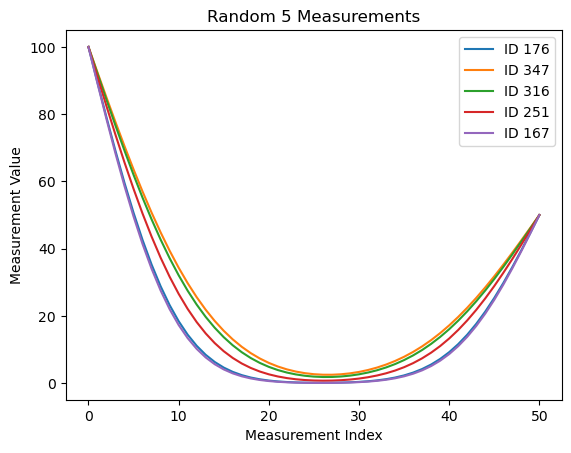

In [42]:
left_up = 300.
left_down = 100.
right_up = 350.
right_down = 50.
init_up = 150.
init_down = 0.
num_points = 8
L_up = 1.5
L_down = 1.25




parameter_table_new,measurement_table, grid_table = generate_unsteady_state_1D_cond(left_up,left_down,right_up,right_down, init_up,init_down,L_up, L_down,num_points)

print(parameter_table_new.shape)
#print(parameter_table_new)
print(measurement_table.shape)
#print(measurement_table)
print(grid_table.shape)

num_random_measurements = 5

# Plot random measurements and print corresponding parameters from the default simulation
plot_random_measurements(parameter_table_new, measurement_table, num_random_measurements)

In [43]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

params = parameter_table_new[:,1:]
measurem = measurement_table[:,1:]
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(params, measurem, test_size=0.2, random_state=42)

# Standardize input features
scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Standardize output measurements
scaler_y = StandardScaler().fit(y_train)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Build a sequential neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(measurem.shape[1])  # Output layer with 100 units (assuming 100 measurements)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss = model.evaluate(X_test_scaled, y_test_scaled)
print(f"Test Loss: {loss}")

Epoch 1/50
40960/40960 [==============================] - 18s 426us/step - loss: 0.0027 - val_loss: 2.1276e-04
Epoch 2/50
40960/40960 [==============================] - 17s 415us/step - loss: 2.0426e-04 - val_loss: 1.6309e-04
Epoch 3/50
40960/40960 [==============================] - 17s 419us/step - loss: 1.6197e-04 - val_loss: 1.2752e-04
Epoch 4/50
40960/40960 [==============================] - 17s 425us/step - loss: 1.5029e-04 - val_loss: 1.3508e-04
Epoch 5/50
40960/40960 [==============================] - 17s 425us/step - loss: 1.3883e-04 - val_loss: 1.0688e-04
Epoch 6/50
40960/40960 [==============================] - 17s 421us/step - loss: 1.2595e-04 - val_loss: 9.4952e-05
Epoch 7/50
40960/40960 [==============================] - 17s 417us/step - loss: 1.1710e-04 - val_loss: 9.6399e-05
Epoch 8/50
40960/40960 [==============================] - 17s 416us/step - loss: 1.0940e-04 - val_loss: 1.0696e-04
Epoch 9/50
40960/40960 [==============================] - 18s 430us/step - loss: 1.0

(5, 51)
[[205.89160186 187.7858224   47.12676107   1.29041391   3.34616274]
 [205.30770175 196.03656002   9.16979191   1.46469384   4.65350207]
 [249.08178364 138.80593762  37.01611952   1.38545739   2.60372271]
 [275.43848559 290.12936166  58.15509139   1.26670369   1.21353641]
 [282.02796252 335.56766961   1.46249552   1.49106015   3.81494676]]
1/1 [==============================] - 0s 12ms/step


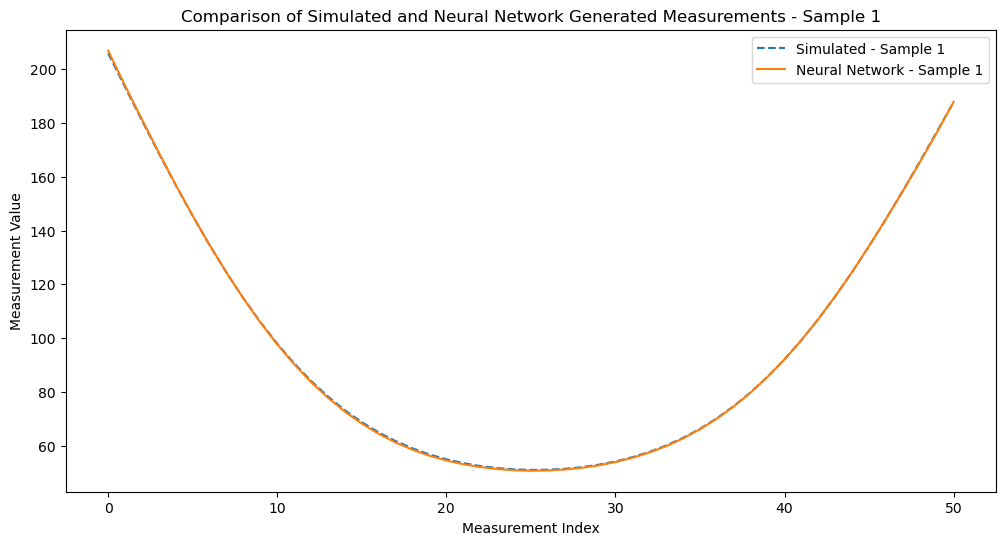

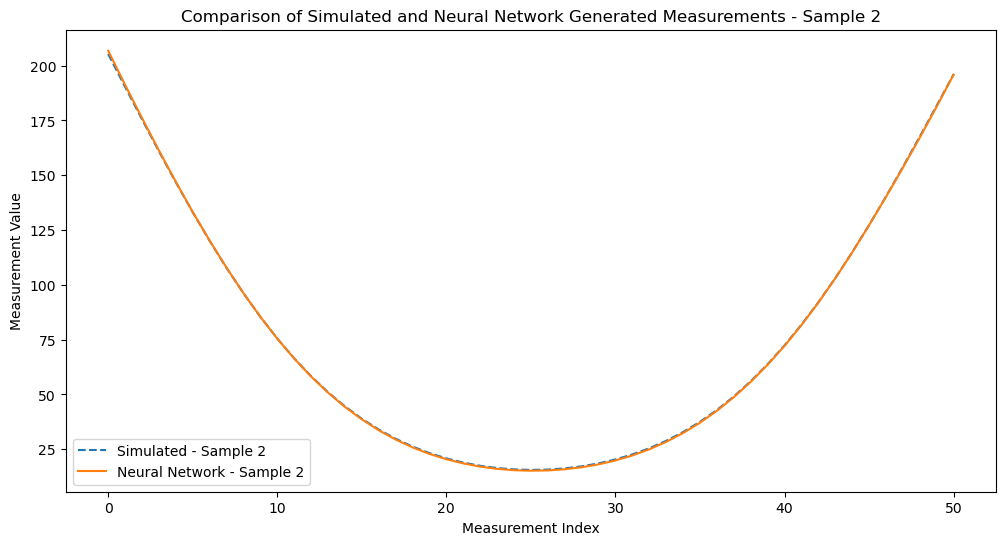

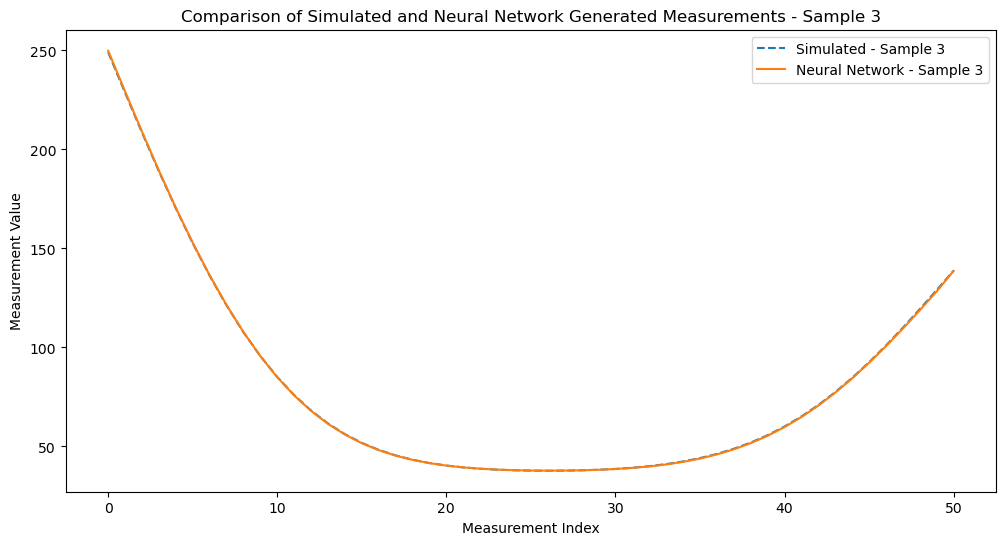

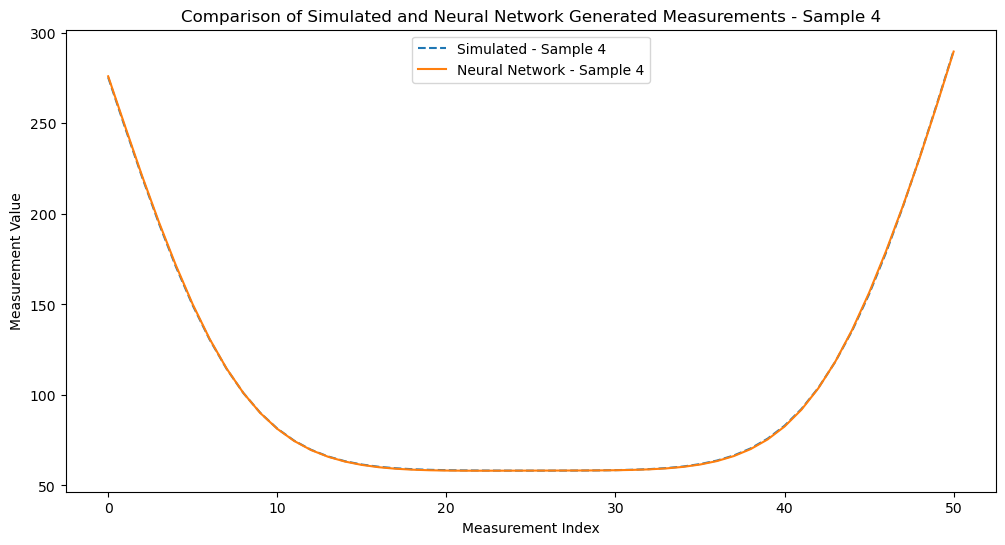

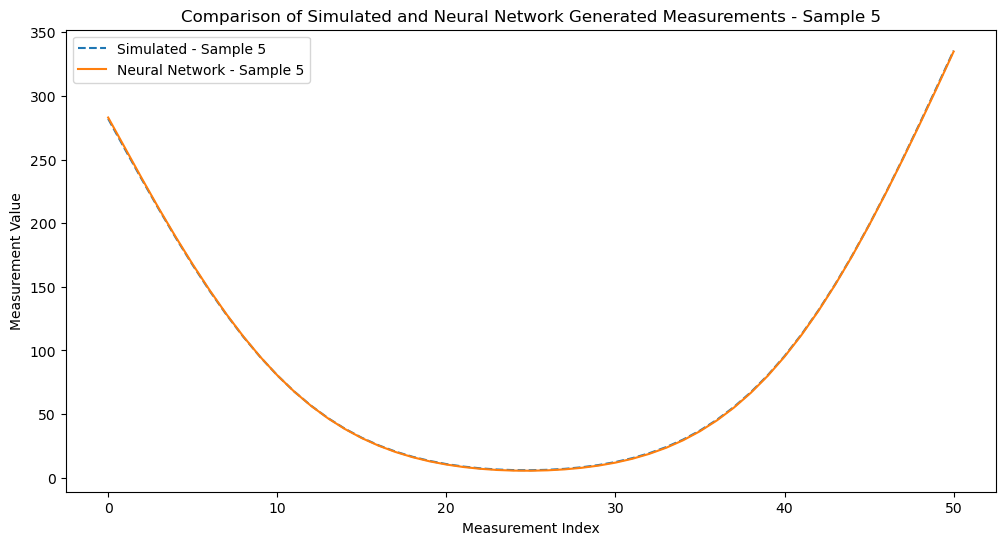

In [54]:
def generate_random_parameters(left_bounds,right_bounds, init_bounds, L_bounds, Tm_bound, num_samples):
    param_bounds = [left_bounds,right_bounds, init_bounds, L_bounds, Tm_bound]
    param_values = [np.random.uniform(bounds[0], bounds[1], num_samples) for bounds in param_bounds]
    param_samples = np.vstack(param_values).T
    return param_samples

def generate_measurements_nn(model, param_samples, scaler_X, scaler_y):
    param_samples_scaled = scaler_X.transform(param_samples)
    measurements_scaled = model.predict(param_samples_scaled)
    measurements = scaler_y.inverse_transform(measurements_scaled)
    return measurements

left_bounds = (left_down, left_up)
right_bounds = (right_down, right_up)
init_bounds = (init_down, init_up)
L_bounds = (L_down, L_up)

Tm_down = 1.0
Tm_up = 5.0
Tm_bounds = (Tm_down, Tm_up)

num_samples = 5
random_parameters = generate_random_parameters(left_bounds,right_bounds, init_bounds, L_bounds, Tm_bounds, num_samples)
#print(random_parameters)

measurements_simulated = np.vstack([simuluate_unsteady_fdm_Tm(left,right,init,L,Tm) for left,right,init,L,Tm in random_parameters])
print(measurements_simulated.shape)
print(random_parameters)
#print(dt)
#measurements_simulated = np.where(measurements_simulated[:, -1] == random_parameters[-1])[0]

# Generate measurements using the trained neural network
measurements_nn = generate_measurements_nn(model, random_parameters, scaler_X, scaler_y)
#print("Random Parameter Samples:")
#print(random_parameters)
#measurements_nn

for i in range(num_samples):
    plt.figure(figsize=(12, 6))
    plt.plot(measurements_simulated[i], label=f'Simulated - Sample {i+1}', linestyle='--')
    plt.plot(measurements_nn[i], label=f'Neural Network - Sample {i+1}')
    plt.xlabel('Measurement Index')
    plt.ylabel('Measurement Value')
    plt.legend()
    plt.title(f'Comparison of Simulated and Neural Network Generated Measurements - Sample {i+1}')
    plt.show()

In [52]:
model.save('1D_cond_NN_pred_unsteady.h5')

/data/anaconda3/envs/load_curve/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


(5, 51)
[[136.76411211 292.66273778  54.82943791   1.31788845  10.41338693]
 [290.44439824  52.00956556  89.72707206   1.31437799  10.2372585 ]
 [130.26854658 265.60459686  45.65952344   1.47690346  12.84834314]
 [122.36110657 109.44070761 100.42035864   1.30053664  10.88005479]
 [126.13388392  95.71627922 138.97401443   1.40663343  12.03713784]]
1/1 [==============================] - 0s 10ms/step


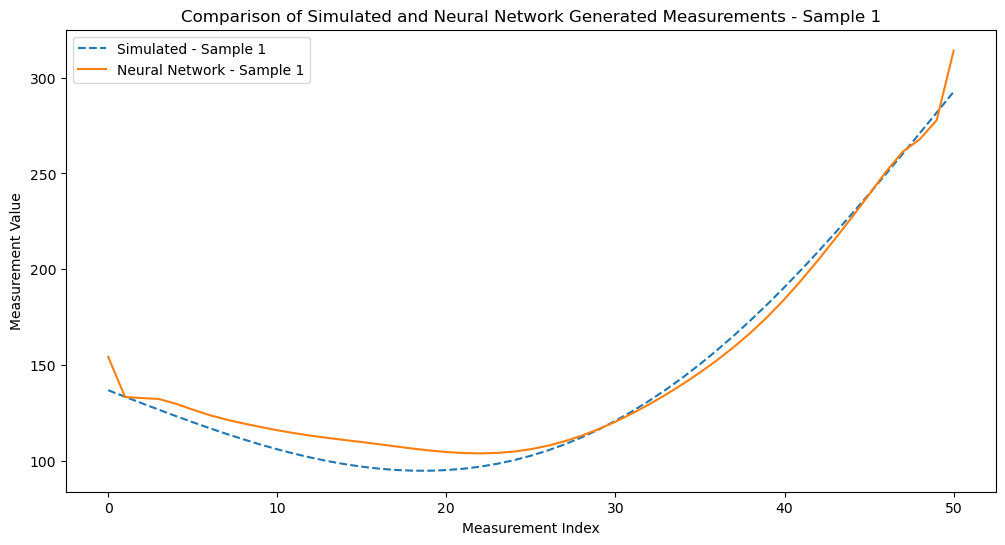

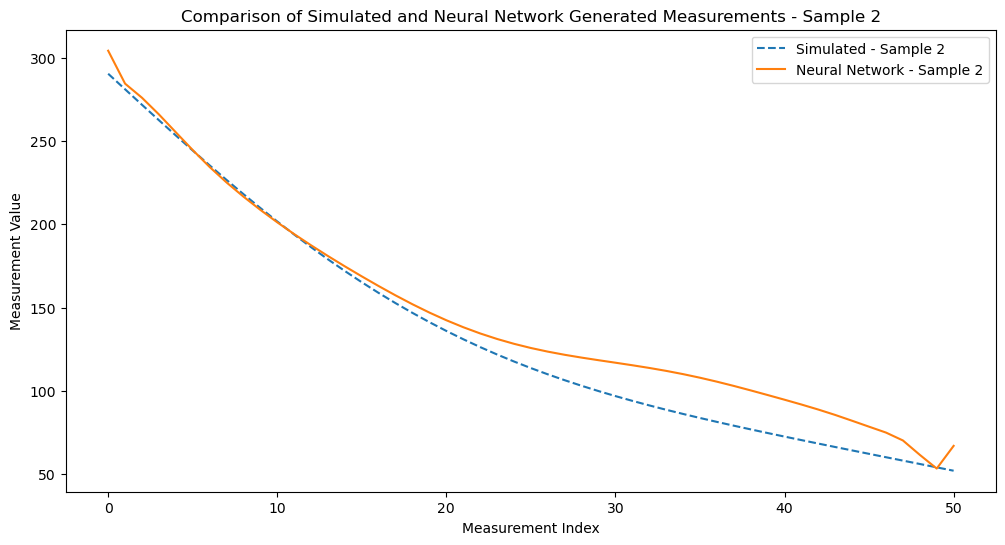

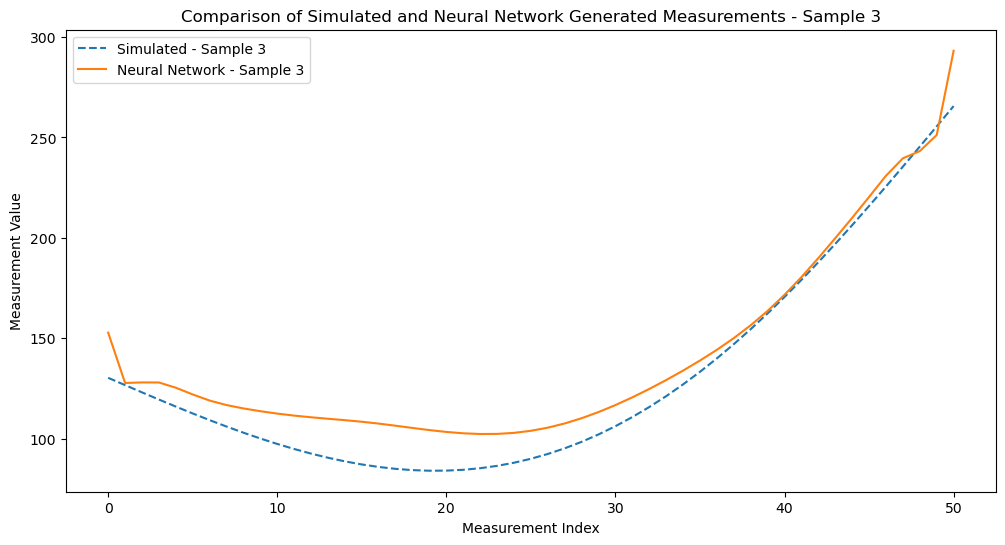

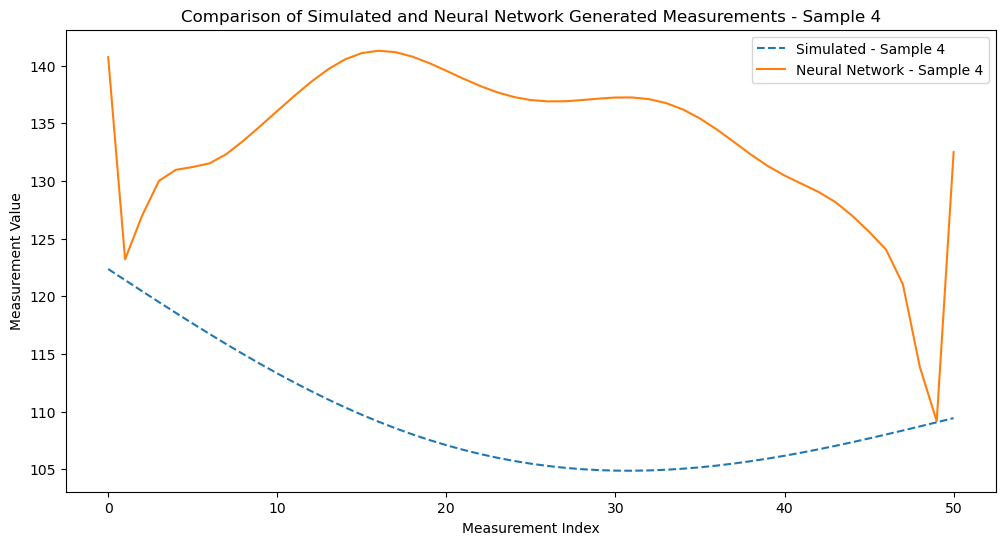

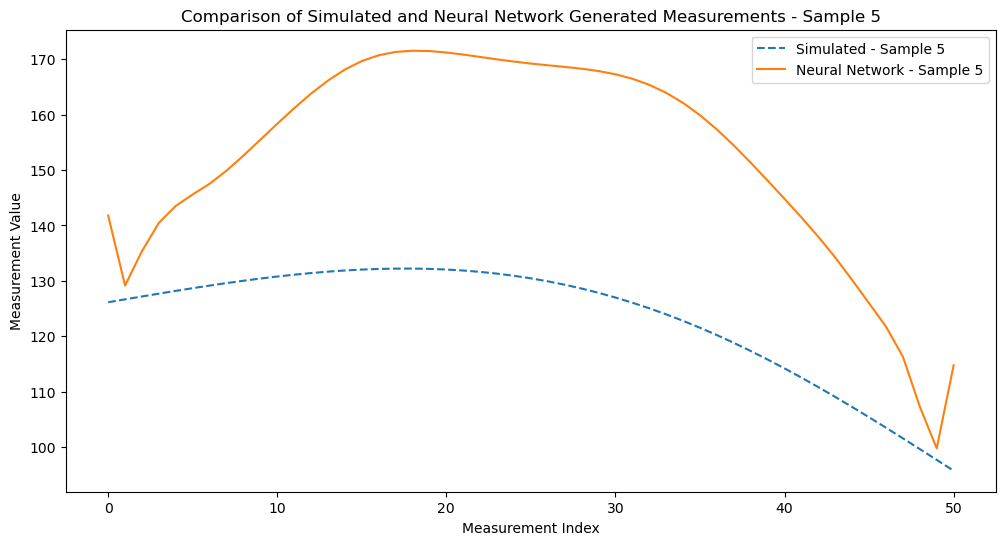

In [56]:
#Extrapolation
Tm_down = 10.0
Tm_up = 15.0
Tm_bounds = (Tm_down, Tm_up)

num_samples = 5
random_parameters = generate_random_parameters(left_bounds,right_bounds, init_bounds, L_bounds, Tm_bounds, num_samples)
#print(random_parameters)

measurements_simulated = np.vstack([simuluate_unsteady_fdm_Tm(left,right,init,L,Tm) for left,right,init,L,Tm in random_parameters])
print(measurements_simulated.shape)
print(random_parameters)
#print(dt)
#measurements_simulated = np.where(measurements_simulated[:, -1] == random_parameters[-1])[0]

# Generate measurements using the trained neural network
measurements_nn = generate_measurements_nn(model, random_parameters, scaler_X, scaler_y)
#print("Random Parameter Samples:")
#print(random_parameters)
#measurements_nn

for i in range(num_samples):
    plt.figure(figsize=(12, 6))
    plt.plot(measurements_simulated[i], label=f'Simulated - Sample {i+1}', linestyle='--')
    plt.plot(measurements_nn[i], label=f'Neural Network - Sample {i+1}')
    plt.xlabel('Measurement Index')
    plt.ylabel('Measurement Value')
    plt.legend()
    plt.title(f'Comparison of Simulated and Neural Network Generated Measurements - Sample {i+1}')
    plt.show()